In [23]:
import pandas as pd
import numpy as np
from surprise import Dataset
from tqdm import tqdm
import matplotlib.pyplot as plt

# Загрузка данных

Используем датасет movielens рейтингов фильмов https://grouplens.org/datasets/movielens/

In [2]:
data = Dataset.load_builtin('ml-100k')
df = pd.DataFrame(data.raw_ratings)
df.columns = ['user', 'item', 'rating', 'timestamp']
df.drop(columns = 'timestamp', inplace = True)

# 1. KNN

https://surprise.readthedocs.io/en/stable/knn_inspired.html

In [3]:
def euclidean_distance(x, y):
    u = np.diagonal((x @ x.T)).reshape(x.shape[0], 1)   # квадраты векторов из матрицы x
    v = np.diagonal(y @ y.T).reshape(1, y.shape[0])     # квадраты векторов из матрицы y
    # приводим к нужной размерности, так как на выходе должна быть матрица попарных расстояний
    u = u @ np.ones(y.shape[0]).reshape(1, y.shape[0])
    v = np.ones(x.shape[0]).reshape(x.shape[0], 1) @ v
    return np.sqrt(u + v - 2*(x @ y.T))  # вычитаем попарные скалярные произведения векторов из x и векторов из y


def cosine_distance(x, y): # 1- cos(x,y); cos(x,y) = (x,y)/|x||y|
    u = np.sqrt(np.diagonal((x @ x.T)).reshape(x.shape[0], 1))  # длины векторов из матрицы x
    v = np.sqrt(np.diagonal(y @ y.T).reshape(1, y.shape[0]))    # длины векторов из матрицы y
    # приводим к нужной размерности, так как на выходе должна быть матрица попарных расстояний
    u = u @ np.ones(y.shape[0]).reshape(1, y.shape[0])
    v = np.ones(x.shape[0]).reshape(x.shape[0], 1) @ v
    return 1 - x @ y.T / u / v          # делим скалярные произведения векторов их на длины

In [4]:
class Knn:
    def __init__(self, k = 10, min_k = 1, similarity='cosine', mode = 'user_based'):
        if similarity == 'euclidean':
            self.simil = euclidean_distance
        elif similarity == 'cosine':
            self.simil = cosine_distance
        else:
            raise ValueError("Metric is not supported", similarity)
        if mode not in ('user_based', 'item_based'):
            raise ValueError("Algorithm mode is not supported", mode)
            
        self.k = k
        self.min_k = min_k
        self.similarity = similarity
        self.mode = mode
        self.test_split_flag = False
        self.eps = 1e-5
    
    def fit(self, X):
         
        self.R = X.pivot(index='user', columns='item', values='rating').fillna(0).values
    
    def train_test_split(self, test_size = 10): # test_size количество объектов, для каждого пользователя, рейтинги которых делаем нанами
        self.test_split_flag = True
        
        def make_test(a):
            notnans = np.argwhere(a > 0).reshape(-1)
            # выберем по 10 not nan значений из кажой строки
            notnans_sample = np.random.randint(0, int(len(notnans)), size = test_size)
            return notnans[notnans_sample]  # возвращаем индексы выбранных значений
        
        self.test_split = np.apply_along_axis(make_test, 1, self.R)    
        self.test_ratings = np.take_along_axis(self.R, self.test_split, 1)
        
        for i in range(len(self.R)):  # формируем обучающую выборку, заполняя выбранные ранее элементы нулями
            self.R[i][self.test_split[i]] = 0
            
        
        if self.mode == 'user_based':
            self.users_mean_rating = np.mean(self.R, axis = 1)
        if self.mode == 'item_based':
            self.items_mean_rating = np.mean(self.R, axis = 0)
            
        #  проверим, что нет таких объектов и пользователей, у которых вообще нет оценок после создания тестовой выборки 
        if self.mode == 'user_based':
            for i in range(self.R.shape[0]):
                if self.R[i,:].sum() == 0:
                    self.R[i,:] = self.R.mean()    
        if self.mode == 'item_based':
            for i in range(self.R.shape[1]):
                if self.R[:,i].sum() == 0:
                    self.R[:,i] = self.R.mean()      
        

    def kneighbors(self):  
        distances = self.simil(self.R, self.R)
        if self.similarity == 'cosine':
            similarities = 1 - distances
        if self.similarity == 'euclidean':
            similarities = 1 / (self.eps + distances) 
        indices = np.argsort(distances, axis = 1)            
        return similarities, indices[:,1:]  # не учитываем, что сам объект является ближайшим к самому себе 

    def predict(self): 
        if self.mode == 'item_based':
            self.R = self.R.T
        similarities, indices = self.kneighbors()
        self.count_rating(indices, similarities)
    
    def rmse(self):
        if self.test_split_flag:
            if self.mode == 'user_based':
                self.pred_test_ratings = np.take_along_axis(self.R, self.test_split, 1)
            if self.mode == 'item_based':
                self.pred_test_ratings = np.take_along_axis(self.R.T, self.test_split, 1)
            return np.mean((self.pred_test_ratings - self.test_ratings)**2)
        else:
            print("can't count mistake, as there is no test data")
            return np.NaN

### 1.1 KNNBasic

In [28]:
class KnnBasic(Knn):
    
    def count_rating(self, indices, similarities):
        for i in range(self.R.shape[1]):
            for u in range(self.R.shape[0]):
                if self.R[u,i] == 0:
                    j = 0
                    r = 0
                    const = 0
                    for v in indices[u]:
                        if  self.R[v,i] != 0:
                            r += similarities[u,v] * self.R[v,i]
                            const += similarities[u,v]
                            j += 1

                        if j == self.k:
                            break
                    if j < self.min_k:
                        if self.mode == 'user_based':
                            self.R[u,i] = self.users_mean_rating[u]
                        if self.mode == 'item_based':
                            self.R[u,i] = self.items_mean_rating[u]
                    else:
                        self.R[u,i] = r/const

In [6]:
np.random.seed(0)

In [7]:
model = KnnBasic(mode = 'user_based')

In [8]:
model.fit(df)

In [9]:
model.train_test_split()

In [10]:
model.predict()

In [11]:
model.rmse()

1.1257134181930302

### 1.2 KNNWithMeans

In [29]:
class KnnWithMeans(Knn):
    
    def count_rating(self, indices, similarities):
        for i in range(self.R.shape[1]):
            for u in range(self.R.shape[0]):
                if self.R[u,i] == 0:
                    j = 0
                    r = 0
                    const = 0
                    if self.mode == 'user_based':
                        mean_u = self.users_mean_rating[u]
                    if self.mode == 'item_based':
                        mean_u = self.items_mean_rating[u]
                    for v in indices[u]:
                        if self.mode == 'user_based':
                            mean_v = self.users_mean_rating[v]
                        if self.mode == 'item_based':
                            mean_v = self.items_mean_rating[v]
                            
                        if  self.R[v,i] != 0:
                            r += similarities[u,v] * (self.R[v,i] - mean_v)
                            const += similarities[u,v]
                            j += 1

                        if j == self.k:
                            break
                    if j < self.min_k:
                        if self.mode == 'user_based':
                            self.R[u,i] = self.users_mean_rating[u]
                        if self.mode == 'item_based':
                            self.R[u,i] = self.items_mean_rating[u]
                    else:
                        self.R[u,i] = mean_u + r/const

In [13]:
np.random.seed(0)

In [14]:
model = KnnWithMeans(mode = 'item_based')

In [15]:
model.fit(df)

In [16]:
model.train_test_split()

model.predict()

model.rmse()

2.5109315727220105

# 2. SVD(Funk MF + bias)

https://surprise.readthedocs.io/en/stable/matrix_factorization.html

In [7]:
class SVD:
    def __init__(self, n_factors = 10, n_epochs = 20, biased=True, 
                 init_mean=0, init_std_dev=0.1, lr_bu=1e-6, lr_bi=1e-6, lr_pu=1e-3, lr_qi=1e-3,
                 reg_bu=0, reg_bi=0, reg_pu=0.1, reg_qi=0.1):

        self.n_factors = n_factors
        self.n_epochs = n_epochs
        self.biased = biased
        self.init_mean = init_mean
        self.init_std_dev = init_std_dev
        self.lr_bu = lr_bu
        self.lr_bi = lr_bi
        self.lr_qi = lr_qi
        self.lr_pu = lr_pu
        self.reg_pu = reg_pu
        self.reg_qi = reg_qi
        self.reg_bu = reg_bu
        self.reg_bi = reg_bi
        self.test_split_flag = False
    
    def fit(self, X):             
        self.R = X.pivot(index='user', columns='item', values='rating').fillna(0).values
    
    def train_test_split(self, test_size = 10): # test_size количество объектов, для каждого пользователя, рейтинги которых делаем нанами
        self.test_split_flag = True
        def make_test(a):
            notnans = np.argwhere(a > 0).reshape(-1)
            # выберем по 10 not nan значений из кажой строки
            notnans_sample = np.random.randint(0, int(len(notnans)), size = test_size)
            return notnans[notnans_sample]  # возвращаем индексы выбранных значений
        
        self.test_split = np.apply_along_axis(make_test, 1, self.R)    
        self.test_ratings = np.take_along_axis(self.R, self.test_split, 1)
        
        for i in range(len(self.R)):  # формируем обучающую выборку, заполняя выбранные ранее элементы нулями
            self.R[i][self.test_split[i]] = 0    
 
        #  проверим, что нет таких пользователей, у которых вообще нет оценок после создания тестовой выборки 
        for i in range(self.R.shape[0]):
            if self.R[i,:].sum() == 0:
                self.R[i,:] = self.R.mean()    
    
    def predict(self): 
        self.users_mean_rating = np.mean(self.R, axis = 1)
        self.items_mean_rating = np.mean(self.R, axis = 0)
        self.mean = self.R.mean()
        self.solver()
        self.R = self.R_est
   
    def rmse(self):
        if self.test_split_flag:
            self.pred_test_ratings = np.take_along_axis(self.R, self.test_split, 1)
            return np.mean((self.pred_test_ratings - self.test_ratings)**2)
        else:
            print("can't count mistake, as there is no test data")
            return np.NaN

### 2.1. Метод оптимизации SGD

In [8]:
class SVD_SGD(SVD):
    def solver(self):
        self.P = self.init_mean + self.init_std_dev * np.random.randn(self.R.shape[0], self.n_factors)
        self.Q = self.init_mean + self.init_std_dev * np.random.randn(self.n_factors, self.R.shape[1])
        if self.biased:
            self.R_est = self.mean + self.users_mean_rating.reshape(-1,1) + self.items_mean_rating.reshape(1,-1) + self.P @ self.Q
            for j in range(self.n_epochs):
                for u in np.random.permutation(range(self.R.shape[0])):
                    for i in np.random.permutation(range(self.R.shape[1])):
                        if self.R[u,i] != 0:
                            self.users_mean_rating = self.users_mean_rating + self.lr_bu * (self.R[u,i] - self.R_est[u,i] - self.reg_bu * self.users_mean_rating)
                            self.items_mean_rating = self.items_mean_rating + self.lr_bi * (self.R[u,i] - self.R_est[u,i] - self.reg_bi * self.items_mean_rating)
                            self.P[u,:] = self.P[u,:] + self.lr_pu * ((self.R[u,i] - self.R_est[u,i]) * self.Q[:,i] - self.reg_pu * self.P[u,:])
                            self.Q[:,i] = self.Q[:,i] + self.lr_qi * ((self.R[u,i] - self.R_est[u,i]) * self.P[u,:] - self.reg_qi * self.Q[:,i])
                self.R_est = self.mean + self.users_mean_rating.reshape(-1,1) + self.items_mean_rating.reshape(1,-1) + self.P @ self.Q
        else:
            self.R_est = self.P @ self.Q
            for j in range(self.n_epochs):
                for u in np.random.permutation(range(self.R.shape[0])):
                    for i in np.random.permutation(range(self.R.shape[1])):
                        if self.R[u,i] != 0:
                            self.P[u,:] = self.P[u,:] + self.lr_pu * ((self.R[u,i] - self.R_est[u,i]) * self.Q[:,i] - self.reg_pu * self.P[u,:])
                            self.Q[:,i] = self.Q[:,i] + self.lr_qi * ((self.R[u,i] - self.R_est[u,i]) * self.P[u,:] - self.reg_qi * self.Q[:,i])
                self.R_est = self.P @ self.Q

In [25]:
np.random.seed(0)

model = SVD_SGD()

model.fit(df)

model.train_test_split()

model.predict()

model.rmse()

1.3646777528611778

### 2.2. Метод оптимизации ALS

http://stanford.edu/~rezab/classes/cme323/S15/notes/lec14.pdf

In [9]:
class SVD_ALS(SVD):
    def solver(self):
        self.P = self.init_mean + self.init_std_dev * np.random.randn(self.R.shape[0], self.n_factors)
        self.Q = self.init_mean + self.init_std_dev * np.random.randn(self.n_factors, self.R.shape[1])
        for j in range(self.n_epochs):
            for u in range(self.R.shape[0]):
                self.A = np.zeros((self.n_factors, self.n_factors))
                self.b = np.zeros(self.n_factors)
                for i in np.argwhere(model.R[u,:] != 0).reshape(-1):
                    self.A += self.Q[:,i].reshape(-1,1) @ self.Q[:,i].reshape(1,-1)
                    if self.biased:
                        self.b += (self.R[u,i] - (self.mean + self.users_mean_rating[u] + self.items_mean_rating[i])) * self.Q[:,i]
                    else:
                        self.b += self.R[u,i] * self.Q[:,i]
                self.A += self.reg_pu * np.eye(self.n_factors)
                
                self.P[u,:] = np.linalg.solve(self.A, self.b)        

            for i in range(self.R.shape[1]):
                
                self.A = np.zeros((self.n_factors, self.n_factors))
                self.b = np.zeros(self.n_factors)
                for u in np.argwhere(self.R[:,i] != 0).reshape(-1):
                    self.A += self.P[u,:].reshape(-1,1) @ self.P[u,:].reshape(1,-1)
                    if self.biased:
                        self.b += (self.R[u,i] - (self.mean + self.users_mean_rating[u] + self.items_mean_rating[i])) * self.P[u,:]
                    else:
                        self.b += self.R[u,i] * self.P[u,:]
                self.A += self.reg_qi * np.eye(self.n_factors)
                
                self.Q[:,i] = np.linalg.solve(self.A, self.b)
                        
        self.R_est = self.mean + self.users_mean_rating.reshape(-1,1) + self.items_mean_rating.reshape(1,-1) + self.P @ self.Q

In [218]:
np.random.seed(0)

model = SVD_ALS()

model.fit(df)

model.train_test_split()

In [219]:
model.predict()

model.rmse()

1.69534885399063

# 3. SVD++

https://surprise.readthedocs.io/en/stable/matrix_factorization.html#unbiased-note

In [10]:
class SVDpp:
    def __init__(self, n_factors = 10, n_epochs = 20, init_mean=0, init_std_dev=0.1, 
                 lr_bu=1e-6, lr_bi=1e-6, lr_pu=1e-3, lr_qi=1e-3, lr_yj = 1e-3, 
                 reg_bu=0, reg_bi=0, reg_yj=0.1, reg_pu=0.1, reg_qi=0.1):

        self.n_factors = n_factors
        self.n_epochs = n_epochs
        self.init_mean = init_mean
        self.init_std_dev = init_std_dev
        self.lr_bu = lr_bu
        self.lr_bi = lr_bi
        self.lr_qi = lr_qi
        self.lr_pu = lr_pu
        self.lr_yj = lr_yj
        self.reg_pu = reg_pu
        self.reg_qi = reg_qi
        self.reg_yj = reg_yj
        self.reg_bu = reg_bu
        self.reg_bi = reg_bi
        
        self.test_split_flag = False
    
    def fit(self, X):             
        self.R = X.pivot(index='user', columns='item', values='rating').fillna(0).values
    
    def train_test_split(self, test_size = 10): # test_size количество объектов, для каждого пользователя, рейтинги которых делаем нанами
        self.test_split_flag = True
        def make_test(a):
            notnans = np.argwhere(a > 0).reshape(-1)
            # выберем по 10 not nan значений из кажой строки
            notnans_sample = np.random.randint(0, int(len(notnans)), size = test_size)
            return notnans[notnans_sample]  # возвращаем индексы выбранных значений
        
        self.test_split = np.apply_along_axis(make_test, 1, self.R)    
        self.test_ratings = np.take_along_axis(self.R, self.test_split, 1)
        
        for i in range(len(self.R)):  # формируем обучающую выборку, заполняя выбранные ранее элементы нулями
            self.R[i][self.test_split[i]] = 0    
 
        #  проверим, что нет таких пользователей, у которых вообще нет оценок после создания тестовой выборки 
        for i in range(self.R.shape[0]):
            if self.R[i,:].sum() == 0:
                self.R[i,:] = self.R.mean()    
    
    def predict(self): 
        self.users_mean_rating = np.mean(self.R, axis = 1)
        self.items_mean_rating = np.mean(self.R, axis = 0)
        self.mean = self.R.mean()
        self.solver()
        self.R = self.R_est
   
    def rmse(self):
        if self.test_split_flag:
            self.pred_test_ratings = np.take_along_axis(self.R, self.test_split, 1)
            return np.mean((self.pred_test_ratings - self.test_ratings)**2)
        else:
            print("can't count mistake, as there is no test data")
            return np.NaN

In [11]:
class SVDpp_SGD(SVDpp):
    def solver(self):
        # заполняем начальные значения 
        self.P = self.init_mean + self.init_std_dev * np.random.randn(self.R.shape[0], self.n_factors)
        self.Q = self.init_mean + self.init_std_dev * np.random.randn(self.n_factors, self.R.shape[1])
        self.Y = self.init_mean + self.init_std_dev * np.random.randn(self.n_factors, self.R.shape[1])
        self.I = np.sum(self.R.astype(bool), axis = 1)
        self.R_est = self.mean + self.users_mean_rating.reshape(-1,1) + self.items_mean_rating.reshape(1,-1)
        self.Y_sum = np.zeros((self.R.shape[0], self.n_factors))
        
        for u in range(self.R.shape[0]):
            for j in np.argwhere(self.R[u,:] != 0).reshape(-1):
                self.Y_sum[u,:] += self.Y[:,j]
            self.Y_sum[u,:] /= np.sqrt(self.I[u])
            for i in np.argwhere(self.R[u,:] != 0).reshape(-1):   
                self.R_est[u,i] += (self.P[u,:] + self.Y_sum[u,:]) @ self.Q[:,i]
           
        for j in tqdm(range(self.n_epochs)):
            for u in np.random.permutation(range(self.R.shape[0])):
                for i in np.random.permutation(np.argwhere(self.R[u,:] != 0).reshape(-1)): 
                    self.users_mean_rating = self.users_mean_rating + self.lr_bu * (self.R[u,i] - self.R_est[u,i] - self.reg_bu * self.users_mean_rating)
                    self.items_mean_rating = self.items_mean_rating + self.lr_bi * (self.R[u,i] - self.R_est[u,i] - self.reg_bi * self.items_mean_rating)
                    self.P[u,:] += self.lr_pu * ((self.R[u,i] - self.R_est[u,i]) * self.Q[:,i] - self.reg_pu * self.P[u,:])
                    self.Q[:,i] += self.lr_qi * ((self.R[u,i] - self.R_est[u,i]) * (self.P[u,:] + self.Y_sum[u,:]) - self.reg_qi * self.Q[:,i])
                    for k in np.argwhere(self.R[u,:] != 0).reshape(-1):
                        self.Y[:,k] += self.lr_yj * ((self.R[u,i] - self.R_est[u,i]) * self.Q[:,i] / np.sqrt(self.I[u])  - self.reg_yj * self.Y[:,k])
                        
            self.R_est = self.mean + self.users_mean_rating.reshape(-1,1) + self.items_mean_rating.reshape(1,-1)
            self.Y_sum = np.zeros((self.R.shape[0], self.n_factors))
        
            for u in range(self.R.shape[0]):
                for j in np.argwhere(self.R[u,:] != 0).reshape(-1):
                    self.Y_sum[u,:] += self.Y[:,j]
                self.Y_sum[u,:] /= np.sqrt(self.I[u])
                for i in np.argwhere(self.R[u,:] != 0).reshape(-1):   
                    self.R_est[u,i] += (self.P[u,:] + self.Y_sum[u,:]) @ self.Q[:,i]
            

# Сравнение работы алгоритмов

In [13]:
np.random.seed(0)

model = SVDpp_SGD(n_factors = 2, n_epochs = 5)

model.fit(df)

model.train_test_split()

In [14]:
model.predict()

100%|████████████████████████████████████████████| 5/5 [12:07<00:00, 145.57s/it]


In [15]:
model.rmse()

2.8568507334147117

In [12]:
%%time
np.random.seed(0)

model = KnnBasic(mode = 'user_based')

model.fit(df)

model.train_test_split()

model.predict()

model.rmse()

CPU times: user 30.9 s, sys: 73.2 ms, total: 31 s
Wall time: 30.2 s


1.1257134181930302

In [13]:
%%time
np.random.seed(0)

model = KnnWithMeans(mode = 'user_based')

model.fit(df)

model.train_test_split()

model.predict()

model.rmse()

CPU times: user 43.5 s, sys: 168 ms, total: 43.7 s
Wall time: 42.9 s


1.208561987314382

In [14]:
%%time
np.random.seed(0)

model = SVD_SGD(n_factors = 2, n_epochs = 5)

model.fit(df)

model.train_test_split()

model.predict()

model.rmse()

CPU times: user 19.2 s, sys: 112 ms, total: 19.3 s
Wall time: 16.3 s


2.407130130831338

In [16]:
%%time
np.random.seed(0)

model = SVD_SGD(n_factors = 10, n_epochs = 10)

model.fit(df)

model.train_test_split()

model.predict()

model.rmse()

CPU times: user 37.5 s, sys: 116 ms, total: 37.6 s
Wall time: 31.5 s


1.5687833582084172

In [18]:
%%time
np.random.seed(0)

model = SVD_SGD(n_factors = 10, n_epochs = 20)

model.fit(df)

model.train_test_split()

model.predict()

model.rmse()

CPU times: user 1min 14s, sys: 224 ms, total: 1min 14s
Wall time: 1min 2s


1.3646777528611778

In [15]:
%%time

np.random.seed(0)

model = SVD_ALS(n_factors = 2, n_epochs = 5)

model.fit(df)

model.train_test_split()

model.predict()

model.rmse()

CPU times: user 6.33 s, sys: 12 ms, total: 6.34 s
Wall time: 6.32 s


0.9670842371582674

In [17]:
%%time

np.random.seed(0)

model = SVD_ALS(n_factors = 10, n_epochs = 10)

model.fit(df)

model.train_test_split()

model.predict()

model.rmse()

CPU times: user 13.7 s, sys: 28 ms, total: 13.7 s
Wall time: 13.2 s


1.5618201831133214

### Вывод:

Заметим, что методы, основанные на KNN оказались более точными в смысле rmse, но и менее быстрыми, нежели градиентные методы SVD. Если выбрать такое количество n_epochs, чтобы время работы  SVD_SGD было примерно таким же, как и методов основанных на KNN, то можно наблюдать, что точность всё равно у KNN выше. 

SVDpp стоит рассмотреть отдельно, он является самым вычислетельно затратным - работал дольше всех. Стоит также отметить, что для выбранных параметров n_factors = 2, n_epochs = 5 дабы не ожидать исполнения вечность SVDpp не показал прироста в качестве по сравнению с градиентными методами SVD. Так как у SVDpp больше параметров, то и обучается он дольше.

### Зависимость качества (в смысле RMSE) KNN от k

In [31]:
k_range = np.arange(1,20)
rmse_range = []
for k in tqdm(k_range):
    np.random.seed(0)
    model = KnnBasic(k = k, mode = 'user_based')

    model.fit(df)

    model.train_test_split()

    model.predict()

    rmse_range.append(model.rmse())

100%|███████████████████████████████████████████| 19/19 [11:10<00:00, 35.27s/it]


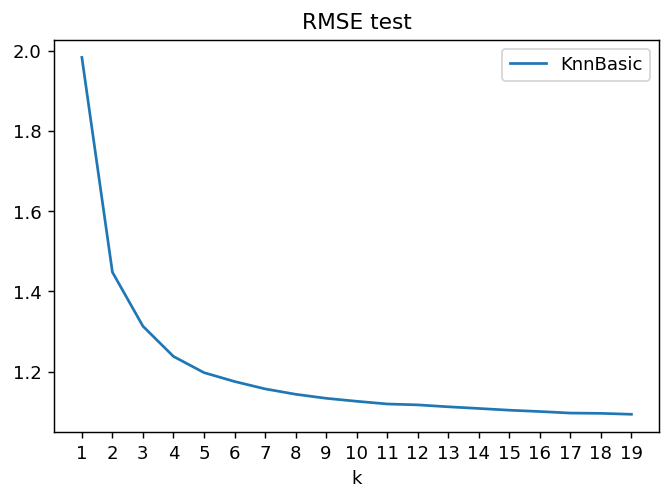

In [32]:
plt.figure(figsize = (6, 4), dpi = 130)
plt.plot(k_range, rmse_range, label = "KnnBasic")
plt.xticks(np.arange(1,20))
plt.xlabel("k")
plt.title("RMSE test")
plt.legend()
plt.show()

Действительно, качество улучшается при увеличении $k$. Видим, как качество постепенно входит на плато, но до точки оптимума пока не дошли.

### Зависимость качества (в смысле RMSE) SVD от числа факторов n_factors

In [35]:
n_factors_range = np.array([2, 5, 10, 15, 20, 30, 40, 50, 75, 100, 150, 200, 300, 400, 500])
rmse_range_n = []
for n in tqdm(n_factors_range):
    np.random.seed(0)

    model = SVD_ALS(n_epochs = 10, n_factors = n)

    model.fit(df)

    model.train_test_split()

    model.predict()

    rmse_range_n.append(model.rmse())

100%|██████████████████████████████████████████| 15/15 [39:56<00:00, 159.74s/it]


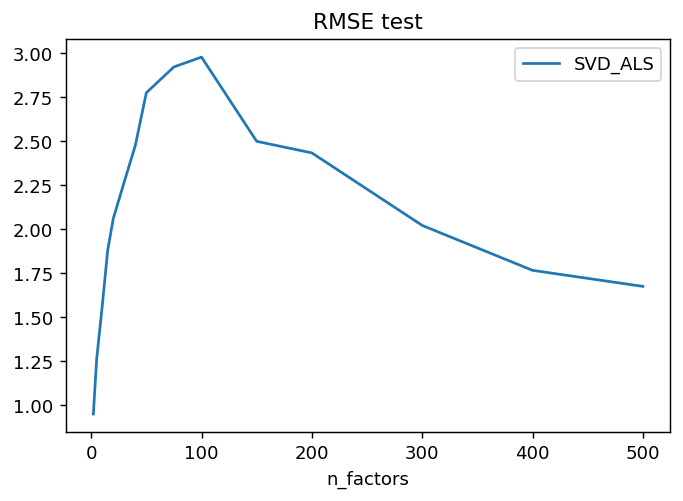

In [36]:
plt.figure(figsize = (6, 4), dpi = 130)
plt.plot(n_factors_range, rmse_range_n, label = "SVD_ALS")
plt.xlabel("n_factors")
plt.title("RMSE test")
plt.legend()
plt.show()

### Зависимость качества (в смысле RMSE) SVD от числа итераций n_epochs в SGD

In [37]:
n_epoch_range = np.arange(2, 23, 4)
rmse_range_epoch = []
for n in tqdm(n_epoch_range):
    np.random.seed(0)

    model = SVD_SGD(n_epochs = n)

    model.fit(df)

    model.train_test_split()

    model.predict()

    rmse_range_epoch.append(model.rmse())

100%|█████████████████████████████████████████████| 6/6 [03:42<00:00, 37.03s/it]


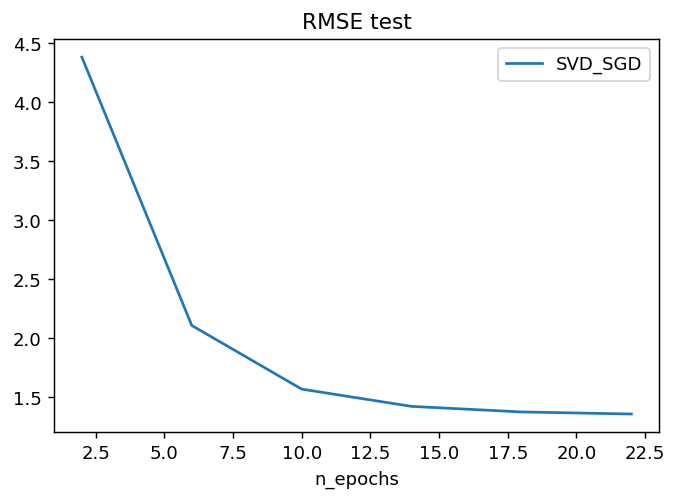

In [38]:
plt.figure(figsize = (6, 4), dpi = 130)
plt.plot(n_epoch_range, rmse_range_epoch, label = "SVD_SGD")
plt.xlabel("n_epochs")
plt.title("RMSE test")
plt.legend()
plt.show()

Действительно, качество улучшается при увеличении числа итераций, с такой скоростью сходится SGD.